In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from tqdm import tqdm
from torch.nn import functional as F
from context_compression.model import GPT, GPTConfig
from context_compression.attn import AttentionKind
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out' # ignored if init_from is not 'resume'
start = "Hello, I'm a language model," # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 10 # number of samples to draw
max_new_tokens = 256 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# init from a model saved in a specific directory


# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304))
# ckpt_path = "/workspace/context-compression/selective_run_0_continued/model_09999.pt"

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304))
# ckpt_path = "/workspace/context-compression/selective_run_0_continued/model_09999.pt"

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False, vocab_size=50304))
# ckpt_path = "/workspace/context-compression/memory_loss_run_0/model_09999.pt"

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELF, for_inference=True, vocab_size=50304))
# ckpt_path = "/workspace/context-compression/unselective_run_0/model_09999.pt"

# model = GPT(GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False, vocab_size=50304))
# ckpt_path = "/root/.cache/huggingface/hub/models--Yorth--selective1/snapshots/1d3d987c90be4b8d6f58de60749ba5823f0ecd29/model.pt"

from huggingface_hub import hf_hub_download
config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304,n_head=13)
model = GPT(config)
ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="self_to_selective_run_0_restarted/model_02499.pt")


checkpoint = torch.load(ckpt_path, map_location=device)

state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)


/tmp/ipykernel_1871/1807403155.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


<All keys matched successfully>

In [2]:

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)


In [7]:
weight = model.transformer.h[0].attn.c_proj.weight
print(weight.shape)
print(weight.sum(dim=0))

torch.Size([768, 832])
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -6.1497e-02,
         1.8793e-01,  7.0836

In [3]:
import numpy as np

B = 4 # micro batch size
T = 1024

from context_compression.data import DataLoaderLite

val_loader = DataLoaderLite(B=B, T=T, split="val", process_rank=0, num_processes=1)

model.eval()
val_loader.reset()
with torch.no_grad():
    val_loss_accum = 0.0
    val_loss_steps = 20
    model.transformer.h[0].attn.FF_values = []  # reset FF values list before validation

    for i in tqdm(range(val_loss_steps)):
        x, y = val_loader.next_batch()
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss, losses = model(x, y)
        loss = loss / val_loss_steps
        val_loss_accum += loss.detach()


print(f"validation loss: {val_loss_accum.item():.4f}")
validation_perplexity = torch.exp(torch.tensor(val_loss_accum.item()))
print(f"validation perplexity: {validation_perplexity:.4f}")

100%|██████████| 20/20 [00:01<00:00, 13.83it/s]

validation loss: 6.3936
validation perplexity: 597.9847


In [4]:
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

generate_samples = False

if False:
    output_file = "generated_samples.txt"
    with open(output_file, 'w', encoding='utf-8') as f:
        with torch.no_grad():
            with ctx:
                # for k in range(num_samples):
                print(x.shape)
                y = model.generate(x.repeat(num_samples, 1), max_new_tokens, temperature=temperature, top_k=top_k)
                generated_texts = [decode(y[i].tolist()) for i in range(num_samples)]

                # Write to file
                for generated_text in generated_texts:
                    f.write(generated_text)
                    f.write('\n' + '-' * 80 + '\n')  # Separator line

                # Optional: Also print to console to see progress
                print(f"Generated samples")

    print(f"\nGeneration complete. Outputs saved to {output_file}")
else:
    print("Skipping generation")

Skipping generation


In [ ]:
from context_compression.hellaswag import render_example, iterate_examples
from context_compression.data import get_most_likely_row

num_correct_norm = 0
num_total = 0
for i, example in tqdm(enumerate(iterate_examples("val"))):
    # render the example into tokens and labels
    _, tokens, mask, label = render_example(example)
    tokens = tokens.to(device)
    mask = mask.to(device)
    # get the logits
    with torch.no_grad():
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss, losses = model(tokens)
        pred_norm = get_most_likely_row(tokens, mask, logits)
    num_total += 1
    num_correct_norm += int(pred_norm == label)
acc_norm = num_correct_norm / num_total
print(f"HellaSwag accuracy: {num_correct_norm}/{num_total}={acc_norm:.4f}")

del logits, loss

# Assert that adding a head doesn't destroy the validation loss

In [13]:
from context_compression.add_a_head import AddHeadConfig, AddHeadKind, add_a_head

# config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False, vocab_size=50304)
# model = GPT(config)
# ckpt_path = "/root/.cache/huggingface/hub/models--Yorth--selective1/snapshots/1d3d987c90be4b8d6f58de60749ba5823f0ecd29/model.pt"

config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=False, vocab_size=50304)
model = GPT(config)
ckpt_path = "/workspace/context-compression/unselective_run_0/model_09999.pt"

add_head_config = AddHeadConfig(add_head_kind=AddHeadKind.GROW_QKV_O, add_head_to_start=True, zero_out_new_head=False)


checkpoint = torch.load(ckpt_path, map_location=device)
# for k,v in checkpoint['model'].items(): print(k)

state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict, strict=False)

add_a_head(config, model, add_head_config)

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

import numpy as np

B = 4 # micro batch size
T = 1024

from context_compression.data import DataLoaderLite

val_loader = DataLoaderLite(B=B, T=T, split="val", process_rank=0, num_processes=1)

model.eval()
val_loader.reset()
with torch.no_grad():
    val_loss_accum = 0.0
    val_loss_steps = 20
    model.transformer.h[0].attn.FF_values = []  # reset FF values list before validation

    for i in tqdm(range(val_loss_steps)):
        x, y = val_loader.next_batch()
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss, losses = model(x, y)
        loss = loss / val_loss_steps
        val_loss_accum += loss.detach()


print(f"validation loss: {val_loss_accum.item():.4f}")
validation_perplexity = torch.exp(torch.tensor(val_loss_accum.item()))
print(f"validation perplexity: {validation_perplexity:.4f}")

/tmp/ipykernel_2548/1270124871.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)
100%|██████████| 20/20 [00:00<00:

validation loss: 3.1433
validation perplexity: 23.1800


# Plot validation loss vs. pruning ratio at 1024 context length

In [9]:
import numpy as np
from context_compression.data import DataLoaderLite

def get_validation_loss_at_diff_ratios(config,ckpt_path):
    model = GPT(config)

    checkpoint = torch.load(ckpt_path, map_location=device)

    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)

    model.eval()
    model.to(device)
    if compile:
        model = torch.compile(model) # requires PyTorch 2.0 (optional)
    

    B = 4 # micro batch size
    T = 1024

    val_loader = DataLoaderLite(B=B, T=T, split="val", process_rank=0, num_processes=1)

    model.eval()

    ratios = np.linspace(0, 1, 5)
    losses = []
    for ratio in tqdm(ratios):
        config.hard_pruning_constant = ratio
        val_loader.reset()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 20
            model.transformer.h[0].attn.FF_values = []  # reset FF values list before validation

            for i in range(val_loss_steps):
                x, y = val_loader.next_batch()
                x, y = x.to(device), y.to(device)
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss, losses = model(x, y)
                loss = loss / val_loss_steps
                val_loss_accum += loss.detach()
        losses.append(val_loss_accum.item())

    return ratios, losses


In [10]:
from huggingface_hub import hf_hub_download


config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304)
ckpt_path = hf_hub_download(repo_id="Yorth/selective1",filename="model.pt")
yorth_ratios, yorth_losses = get_validation_loss_at_diff_ratios(config, ckpt_path)

config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304)
ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="selective_run_0_continued/model_09999.pt")
selective_ratios, selective_losses = get_validation_loss_at_diff_ratios(config, ckpt_path)

config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304)
ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="memory_loss_run_0/model_09999.pt")
memory_loss_ratios, memory_loss_losses = get_validation_loss_at_diff_ratios(config, ckpt_path)

config = GPTConfig(attention_kind=AttentionKind.SELF, for_inference=True, vocab_size=50304)
ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="unselective_run_0/model_09999.pt")
unselective_ratios, unselective_losses = get_validation_loss_at_diff_ratios(config, ckpt_path)

config = GPTConfig(attention_kind=AttentionKind.SELECTIVE, for_inference=True, vocab_size=50304,n_head=13)
ckpt_path = hf_hub_download(repo_id="andrew-healey/context-compression",filename="self_to_selective_run_0_restarted/model_02499.pt")
self_to_selective_ratios, self_to_selective_losses = get_validation_loss_at_diff_ratios(config, ckpt_path)

/tmp/ipykernel_1517/549648252.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)
100%|██████████| 5/5 [00:02<00:00, 

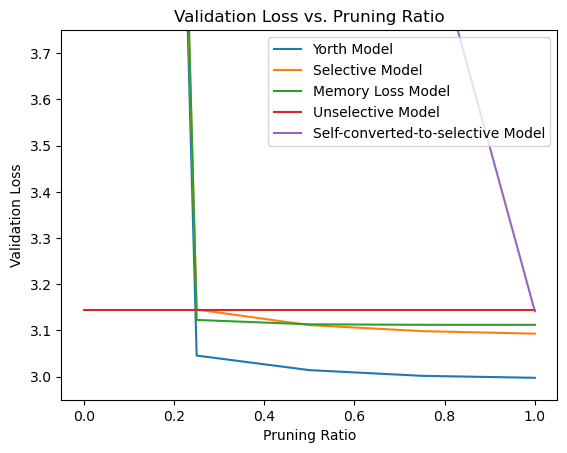

In [13]:
import matplotlib.pyplot as plt


plt.plot(yorth_ratios, yorth_losses, label='Yorth Model')
plt.plot(selective_ratios, selective_losses, label='Selective Model') 
plt.plot(memory_loss_ratios, memory_loss_losses, label='Memory Loss Model')
plt.plot(unselective_ratios, unselective_losses, label='Unselective Model')
plt.plot(self_to_selective_ratios, self_to_selective_losses, label='Self-converted-to-selective Model')
plt.ylim(2.95, 3.75)
plt.title("Validation Loss vs. Pruning Ratio")
plt.xlabel("Pruning Ratio")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()